In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from sklearn.feature_selection import f_classif
import scipy.stats as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.metrics import roc_auc_score,roc_curve, r2_score, mean_squared_error
import pickle
warnings.simplefilter('ignore')

In [2]:
loan_data_preprocessed_backup=pd.read_csv('loan_data_2007_2014_preprocessed.csv')

In [3]:
loan_data_preprocessed=loan_data_preprocessed_backup.copy()

In [4]:
loan_data_preprocessed.shape

(466285, 209)

# Data exploration

In [5]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [6]:
loan_data_preprocessed['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
loan_data_default=loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]
loan_data_default['loan_status'].unique()

array(['Charged Off',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [8]:
loan_data_default.shape

(43236, 209)

In [9]:
pd.options.display.max_rows=None
loan_data_default.isnull().sum()

Unnamed: 0                                                             0
Unnamed: 0.1                                                           0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

# preprocessing


* Null value imputation

In [10]:
loan_data_default['mths_since_last_delinq'].fillna(0,inplace=True)
loan_data_default['mths_since_last_delinq'].isnull().sum()

0

In [11]:
loan_data_default['mths_since_last_record'].fillna(0,inplace=True)
loan_data_default['mths_since_last_record'].isnull().sum()

0

# dependent variable for LGD(loss given default).

In [12]:
loan_data_default['recovery_rate']=loan_data_default['recoveries']/loan_data_default['funded_amnt']

In [13]:
loan_data_default['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

* since this recovery rate value should be in between 0 to 1 so value which lies outside this range that should truncated to 0 or 1. 


In [14]:
loan_data_default['recovery_rate']=np.where(loan_data_default['recovery_rate']<0,0,loan_data_default['recovery_rate'])
loan_data_default['recovery_rate']=np.where(loan_data_default['recovery_rate']>1,1,loan_data_default['recovery_rate'])


In [15]:
loan_data_default['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

# dependent variable for EAD exposure at default

* credit conversion rate: (1- proportion of money which has already paid by the borrowers before default)
* EAD= 'total funded amount' X 'credit conversion factor'
* Credit coversion factor= 1- 'total recovered priceple'/'funded amount'
* total recovered principal: total payment made on principal of the loan.

In [16]:
loan_data_default['CCF']= (loan_data_default['funded_amnt']-loan_data_default['total_rec_prncp'])/loan_data_default['funded_amnt']
loan_data_default['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [17]:
loan_data_default.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate,CCF
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,1,0,0,0.046832,0.817416
8,8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,...,0,0,0,0,0,1,0,0,0.033761,0.971068
9,9,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,...,0,0,0,0,0,1,0,0,0.050100,0.874701
12,12,12,1064687,1298717,9000,9000,9000.0,36 months,13.49,305.38,...,0,0,0,0,0,1,0,0,0.049367,0.860429
14,14,14,1069057,1303503,10000,10000,10000.0,36 months,10.65,325.74,...,0,0,0,0,0,1,0,0,0.064510,0.456653


In [18]:
loan_data_default.to_csv('loan_data_default.csv')

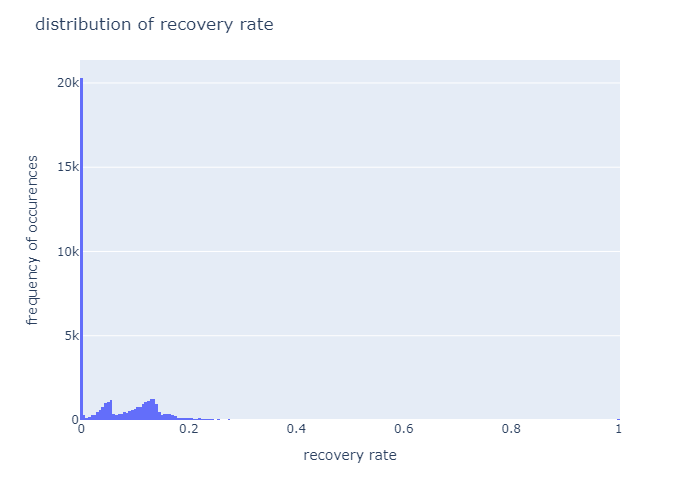

In [19]:
fig=px.histogram(loan_data_default,x='recovery_rate')
fig.update_layout(title='distribution of recovery rate',
                 xaxis=dict(title='recovery rate'),
                  yaxis=dict(title='frequency of occurences')
                 )
fig.show('png')

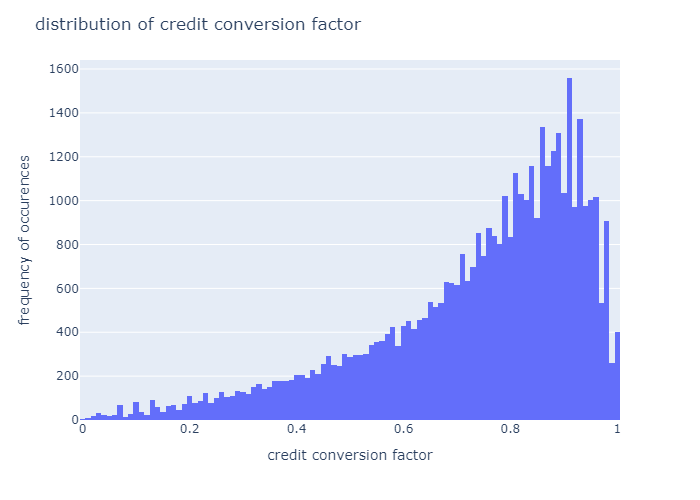

In [20]:
fig=px.histogram(loan_data_default,x='CCF')
fig.update_layout(title='distribution of credit conversion factor',
                 xaxis=dict(title='credit conversion factor'),
                  yaxis=dict(title='frequency of occurences')
                 )
fig.show('png')

* by observing the distribution of recovery rate it is decieded that prediction of this column will be done in two phase
* in first phase with logistic regression it will be predicted that the recovery rate is 0 or not since the frequencey of occurence of 0 is more than frequency of other rate value combined.
* if the prediction value is not zero but more than zero then how much more than zero will be predicted by linear regression.

In [21]:
loan_data_default['recovery_rate_0_1']=np.where(loan_data_default['recovery_rate']==0,0,1)

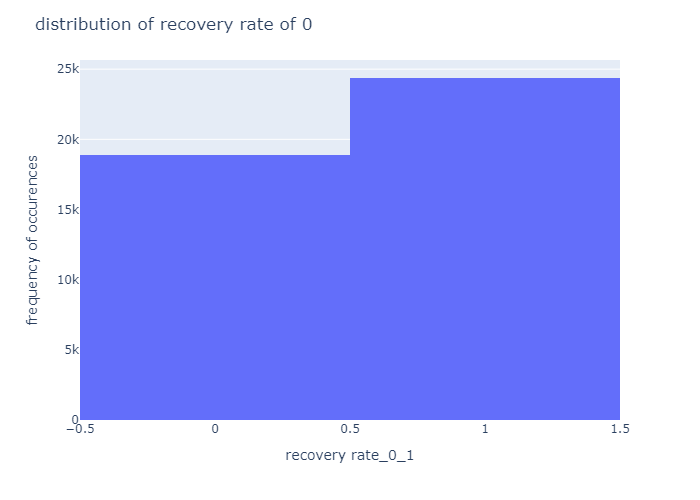

In [22]:
fig=px.histogram(loan_data_default,x='recovery_rate_0_1')
fig.update_layout(title='distribution of recovery rate of 0 ',
                 xaxis=dict(title='recovery rate_0_1'),
                  yaxis=dict(title='frequency of occurences')
                 )
fig.show('png')

# preparing training data to train logistic model to predict that the recovery rate is 0 or more than 0.

In [23]:
# splitting data
lgd_inputs_stage_1_train,lgd_inputs_stage_1_test,lgd_target_stage_1_train,lgd_target_stage_1_test=train_test_split(loan_data_default.drop(columns=['recovery_rate','CCF','recovery_rate_0_1'],axis=1),loan_data_default['recovery_rate_0_1'],test_size=0.2, random_state=42)

In [24]:
lgd_inputs_stage_1_train.shape,lgd_inputs_stage_1_test.shape,lgd_target_stage_1_train.shape,lgd_target_stage_1_test.shape

((34588, 209), (8648, 209), (34588,), (8648,))

In [25]:
# preparing the inputs
feature_all=[
'grade:A',
'grade:B', 
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',

'home_ownership:ANY', 'home_ownership:MORTGAGE',
'home_ownership:NONE', 'home_ownership:OTHER',
'home_ownership:OWN', 'home_ownership:RENT',

'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',

 'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:educational', 'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',

'initial_list_status:f',
'initial_list_status:w',

'term_int',
'emp_length_int',
'Mths_since_issue_d',
'Mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim'
]

In [26]:
feature_reference=[
'grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f',
]

In [27]:
lgd_inputs_stage_1_train=lgd_inputs_stage_1_train[feature_all]
lgd_inputs_stage_1_train.drop(columns=feature_reference,inplace=True,axis=1)

In [28]:
lgd_inputs_stage_1_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
165859,0,0,0,1,0,0,0,0,0,0,...,26.31,0.0,2.0,0.0,0.0,17.0,0.0,34.0,0.0,13700.0
213563,0,0,1,0,0,0,0,0,0,0,...,27.21,0.0,3.0,0.0,0.0,11.0,0.0,13.0,0.0,3000.0
182682,0,0,0,1,0,0,0,0,0,0,...,20.33,0.0,1.0,0.0,0.0,7.0,0.0,38.0,0.0,14600.0
81769,0,0,1,0,0,0,0,1,0,0,...,17.31,0.0,0.0,0.0,68.0,12.0,2.0,30.0,0.0,5800.0
74862,0,0,0,0,1,0,0,0,0,0,...,24.28,0.0,0.0,72.0,0.0,13.0,0.0,35.0,0.0,15900.0


# p value of each column 

In [29]:
f_statistic, p_values = f_classif(lgd_inputs_stage_1_train, lgd_target_stage_1_train)

In [30]:
category_to_pvalue=pd.DataFrame({ 'category Name':lgd_inputs_stage_1_train.columns.values,
                                  'p_value':p_values,
                                  'prefix':lgd_inputs_stage_1_train.columns.str.split(':').str[0]
             })
category_to_pvalue[category_to_pvalue['p_value']>=0.05]

,category Name,p_value,prefix
0,grade:A,0.424808,grade
7,home_ownership:MORTGAGE,0.170322,home_ownership
8,home_ownership:NONE,0.117024,home_ownership
9,home_ownership:OTHER,0.144192,home_ownership
10,home_ownership:OWN,0.427419,home_ownership
11,verification_status:Not Verified,0.889288,verification_status
16,purpose:home_improvement,0.053041,purpose
19,purpose:medical,0.573645,purpose
20,purpose:moving,0.177351,purpose
24,purpose:vacation,0.106564,purpose


# estimating logistic regression model.

In [31]:
model_logistic_stage_1= LogisticRegression()
model_logistic_stage_1.fit(lgd_inputs_stage_1_train,lgd_target_stage_1_train)

LogisticRegression()

In [32]:
lgd_proba_stage_1=model_logistic_stage_1.predict_proba(lgd_inputs_stage_1_train)[:,1]
lgd_proba_stage_1[:5]

array([0.58075604, 0.60306373, 0.52938854, 0.51696073, 0.53238834])

In [33]:
lgd_target_stage_1_train_temp=lgd_target_stage_1_train.copy()

In [34]:
df_predicted_prob_train_stage1=pd.DataFrame({'train_target_stage_1':lgd_target_stage_1_train_temp,
             'train_prob_stage_1':lgd_proba_stage_1
             }).reset_index(drop=True)
df_predicted_prob_train_stage1.head()

,train_target_stage_1,train_prob_stage_1
0,1,0.580756
1,1,0.603064
2,1,0.529389
3,0,0.516961
4,0,0.532388


In [35]:
tr=0.5
df_predicted_prob_train_stage1['predicted_cls']=np.where(df_predicted_prob_train_stage1['train_prob_stage_1']>tr,1,0)
df_predicted_prob_train_stage1.index=lgd_target_stage_1_train.index
confusionMat=pd.crosstab(index=df_predicted_prob_train_stage1['train_target_stage_1'],columns=df_predicted_prob_train_stage1['predicted_cls'],rownames=['actual'],colnames=['prediction'])
confusionMat/df_predicted_prob_train_stage1.shape[0]

prediction,0,1
actual,,
0,0.160460,0.276194
1,0.103735,0.459610


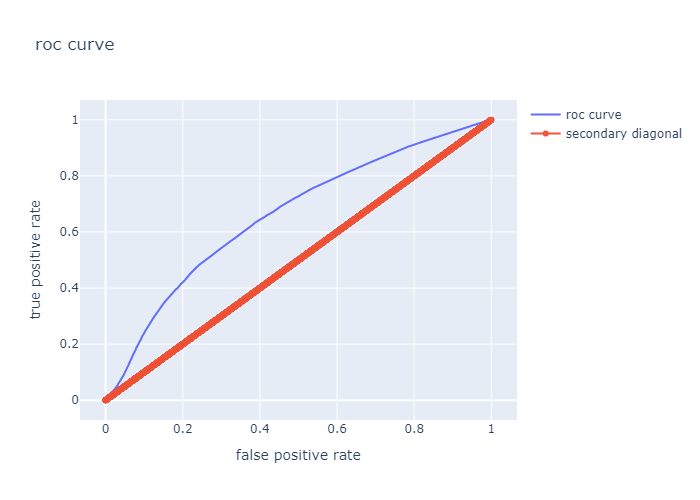

In [36]:
fpr,tpr,thrs=roc_curve(df_predicted_prob_train_stage1['train_target_stage_1'],df_predicted_prob_train_stage1['train_prob_stage_1'])
len(fpr),len(tpr),len(thrs)

fig=go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr,
                    mode='lines',
                    name='roc curve'))
fig.add_trace(go.Scatter(x=fpr, y=fpr,
                    mode='lines+markers',
                    name='secondary diagonal'))
fig.update_layout(title='roc curve ',xaxis=dict(title='false positive rate'),yaxis=dict(title='true positive rate'))
fig.show('png')

In [37]:
print(''' area under the roc curve ''')
roc_auc_score(df_predicted_prob_train_stage1['train_target_stage_1'],df_predicted_prob_train_stage1['train_prob_stage_1'])


 area under the roc curve 


0.6602577755744486

# testing on Test Data

In [38]:
lgd_inputs_stage_1_test=lgd_inputs_stage_1_test[feature_all].drop(columns=feature_reference)

In [39]:
lgd_predict_test_stage_1=model_logistic_stage_1.predict_proba(lgd_inputs_stage_1_test)[:,1]
lgd_predict_test_stage_1[:10]

array([0.58459518, 0.60086235, 0.50287082, 0.51114859, 0.41806325,
       0.5609377 , 0.49890449, 0.57621152, 0.52228165, 0.52816563])

In [40]:
lgd_target_stage_1_test_temp=lgd_target_stage_1_test.copy()

In [41]:
df_predicted_prob_test_stage1=pd.DataFrame({'train_target_stage_1':lgd_target_stage_1_test_temp,
             'train_prob_stage_1':lgd_predict_test_stage_1
             }).reset_index(drop=True)
df_predicted_prob_test_stage1.head()

,train_target_stage_1,train_prob_stage_1
0,1,0.584595
1,1,0.600862
2,0,0.502871
3,1,0.511149
4,0,0.418063


In [42]:
tr=0.5
print(f'for threshold value {tr}')
df_predicted_prob_test_stage1['predicted_cls']=np.where(df_predicted_prob_test_stage1['train_prob_stage_1']>tr,1,0)
df_predicted_prob_test_stage1.index=lgd_target_stage_1_test.index
confusionMat=pd.crosstab(index=df_predicted_prob_test_stage1['train_target_stage_1'],columns=df_predicted_prob_test_stage1['predicted_cls'],rownames=['actual'],colnames=['prediction'])
confusionMat/df_predicted_prob_test_stage1.shape[0]

for threshold value 0.5


prediction,0,1
actual,,
0,0.160731,0.274283
1,0.108696,0.456290


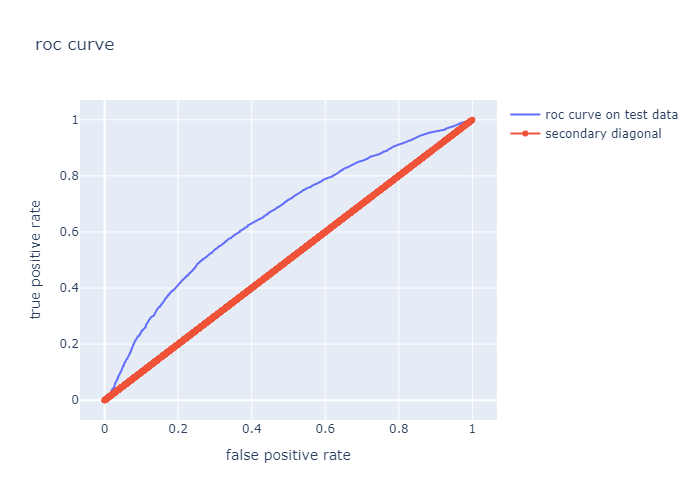

In [43]:
fpr,tpr,thrs=roc_curve(df_predicted_prob_test_stage1['train_target_stage_1'],df_predicted_prob_test_stage1['train_prob_stage_1'])
len(fpr),len(tpr),len(thrs)

fig=go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr,
                    mode='lines',
                    name='roc curve on test data '))
fig.add_trace(go.Scatter(x=fpr, y=fpr,
                    mode='lines+markers',
                    name='secondary diagonal'))
fig.update_layout(title='roc curve ',xaxis=dict(title='false positive rate'),yaxis=dict(title='true positive rate'))
fig.show('png')

In [44]:
print(''' area under the roc curve ''')
roc_auc_score(df_predicted_prob_test_stage1['train_target_stage_1'],df_predicted_prob_test_stage1['train_prob_stage_1'])


 area under the roc curve 


0.6557551515325608

> * area under the ROC curve is good but it is not satisfactory. a better model with fine threshold value should be found.
> * the proportion of predicted borrowers who recovery rate is more than 0, should be more than proportion of predicted  borrowers with recovery rate equal to 0. Because even if classification model is unable to classify some of the account correctly in first stage and most of the borrowers classified as 1 which denotes that their recovery rate is more than 0 but in reality they are not , then in next stage linear regression model may predict the actual recovery rate for them. 

# saving model

# estimating linear regression model.

In [45]:
lgd_stage2_train_inputs=loan_data_default[loan_data_default['recovery_rate_0_1']==1]

In [46]:
lgd_data_stage_2=loan_data_default[loan_data_default['recovery_rate_0_1']==1]

In [47]:
lgd_data_stage_2.shape

(24371, 212)

In [48]:
lgd_inputs_stage2_train,lgd_inputs_stage2_test,lgd_target_stage2_train,lgd_target_stage2_test=train_test_split(lgd_data_stage_2.drop(['recovery_rate','recovery_rate_0_1','CCF'],axis=1),lgd_data_stage_2['recovery_rate'],test_size=0.2,random_state=42)

In [49]:
lgd_inputs_stage2_train.shape,lgd_inputs_stage2_test.shape,lgd_target_stage2_train.shape,lgd_target_stage2_test.shape

((19496, 209), (4875, 209), (19496,), (4875,))

In [50]:
lgd_inputs_stage2_train=lgd_inputs_stage2_train[feature_all].drop(columns=feature_reference)

In [51]:
linearReg_stage2_model=LinearRegression()
linearReg_stage2_model.fit(lgd_inputs_stage2_train,lgd_target_stage2_train)

LinearRegression()

# testing the model

In [52]:
lgd_inputs_stage2_test=lgd_inputs_stage2_test[feature_all].drop(columns=feature_reference)

In [53]:
lgd_predict_stage2_test = linearReg_stage2_model.predict(lgd_inputs_stage2_test)

In [54]:
lgd_target_stage2_test_temp=lgd_target_stage2_test.copy()

In [55]:
df_pred_and_target=pd.DataFrame({'lgd_target_stage2_test':lgd_target_stage2_test_temp.values,
                'lgd_predict_stage2_test':lgd_predict_stage2_test
             })
df_pred_and_target.corr()

,lgd_target_stage2_test,lgd_predict_stage2_test
lgd_target_stage2_test,1.000000,0.307749
lgd_predict_stage2_test,0.307749,1.000000


In [56]:
df_pred_and_target['diff']=df_pred_and_target['lgd_target_stage2_test']-df_pred_and_target['lgd_predict_stage2_test']

In [57]:
''' from the below histogram of residual error it is observed that the distribution is normal
and frequency of occurence of residual error are maximum around zero so it.
So we can say that the model has learn all pattern perfectly.'''

' from the below histogram of residual error it is observed that the distribution is normal\nand frequency of occurence of residual error are maximum around zero so it.\nSo we can say that the model has learn all pattern perfectly.'

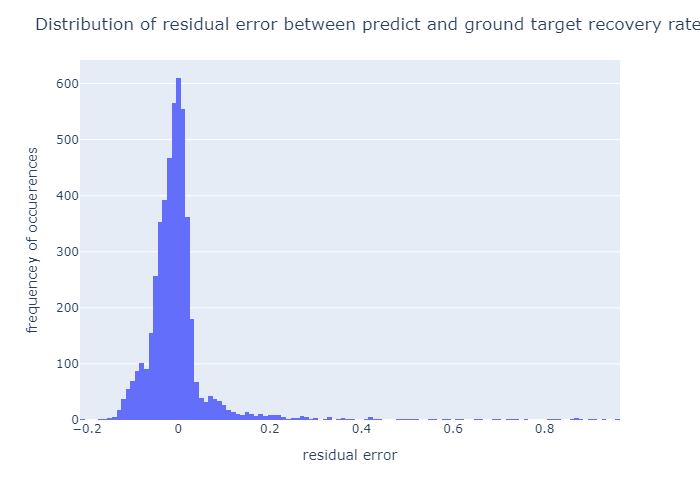

In [58]:
fig=px.histogram(df_pred_and_target,x='diff')
fig.update_layout(title='Distribution of residual error between predict and ground target recovery rate',
                    xaxis=dict(title='residual error'),
                  yaxis=dict(title='frequencey of occuerences')
                 )
fig.show('png')

# combining stage1 and stage 2

In [59]:
# this series contain prediction of logistic regression model on test data 
# this prediction is performed on all rows of the test data.
lgd_prediction_stage1_test=df_predicted_prob_test_stage1['predicted_cls']
lgd_prediction_stage1_test.shape

(8648,)

In [60]:
# prediction of expected recovery rate of test data by linear regression model is in this series. 
lgd_prediction_stage2_test=linearReg_stage2_model.predict(lgd_inputs_stage_1_test)
lgd_prediction_stage2_test.shape

(8648,)

In [61]:
# final answer would be mulitpication of corresponding elements 
final_recovery_rate=pd.DataFrame({'predic_recovery_rate':np.multiply(lgd_prediction_stage1_test,lgd_prediction_stage2_test)})
final_recovery_rate.describe()

,predic_recovery_rate
count,8648.000000
mean,0.076244
std,0.051805
min,-0.006913
25%,0.000000
50%,0.093526
75%,0.116560
max,0.236368


In [62]:
final_recovery_rate['predic_recovery_rate']=np.where(final_recovery_rate['predic_recovery_rate']<0,0,final_recovery_rate['predic_recovery_rate'])
final_recovery_rate['predic_recovery_rate']=np.where(final_recovery_rate['predic_recovery_rate']>1,1,final_recovery_rate['predic_recovery_rate'])


In [63]:
final_recovery_rate.describe()

,predic_recovery_rate
count,8648.000000
mean,0.076245
std,0.051803
min,0.000000
25%,0.000000
50%,0.093526
75%,0.116560
max,0.236368


In [64]:
pickle.dump(model_logistic_stage_1,open('model_logistic_stage_1_LGD.sav','wb'))
pickle.dump(linearReg_stage2_model,open('linearRegModel_stage2_LGD.sav','wb'))


# developing EAD MODEL

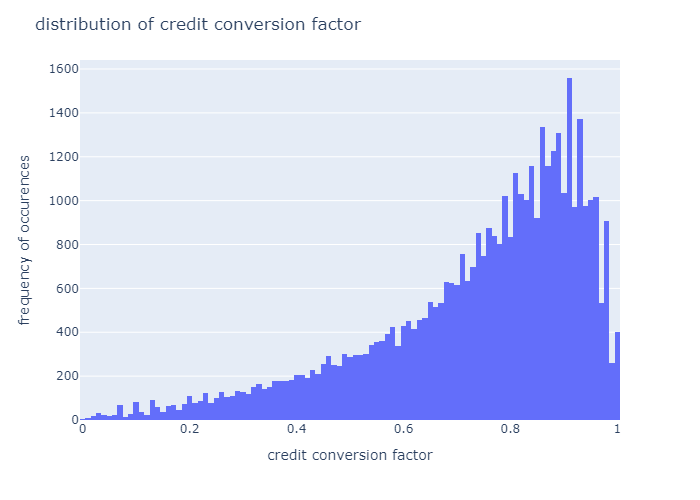

In [65]:
fig=px.histogram(loan_data_default,x='CCF')
fig.update_layout(title='distribution of credit conversion factor',
                 xaxis=dict(title='credit conversion factor'),
                  yaxis=dict(title='frequency of occurences')
                 )
fig.show('png')

In [66]:
ead_inputs_train,ead_inputs_test,ead_target_train, ead_target_test=train_test_split(loan_data_default.drop(columns=['recovery_rate','CCF','recovery_rate_0_1'],axis=1),loan_data_default['CCF'],test_size=0.2,random_state=42)
ead_inputs_train.shape,ead_inputs_test.shape,ead_target_train.shape,ead_target_test.shape

((34588, 209), (8648, 209), (34588,), (8648,))

In [67]:
ead_inputs_train=ead_inputs_train[feature_all].drop(columns=feature_reference)

In [68]:
model_ead_LinearReg=LinearRegression()
model_ead_LinearReg.fit(ead_inputs_train,ead_target_train)

LinearRegression()

# testing the linear regression model on test data

In [69]:
ead_inputs_test=ead_inputs_test[feature_all].drop(columns=feature_reference)

In [70]:
ead_predict_test= model_ead_LinearReg.predict(ead_inputs_test)


In [71]:
CCF_predi_actual=pd.DataFrame({'actualCCF':ead_target_test,
            'predictCCF':ead_predict_test
             })
CCF_predi_actual.describe()

,actualCCF,predictCCF
count,8648.000000,8648.000000
mean,0.733973,0.736011
std,0.201629,0.105199
min,0.011554,0.384798
25%,0.629341,0.661581
50%,0.789212,0.731767
75%,0.886812,0.810523
max,1.000000,1.161196


In [72]:
CCF_predi_actual['predictCCF']=np.where(CCF_predi_actual['predictCCF']<0,0,CCF_predi_actual['predictCCF'])
CCF_predi_actual['predictCCF']=np.where(CCF_predi_actual['predictCCF']>1,1,CCF_predi_actual['predictCCF'])


In [73]:
CCF_predi_actual.describe()

,actualCCF,predictCCF
count,8648.000000,8648.000000
mean,0.733973,0.735990
std,0.201629,0.105132
min,0.011554,0.384798
25%,0.629341,0.661581
50%,0.789212,0.731767
75%,0.886812,0.810523
max,1.000000,1.000000


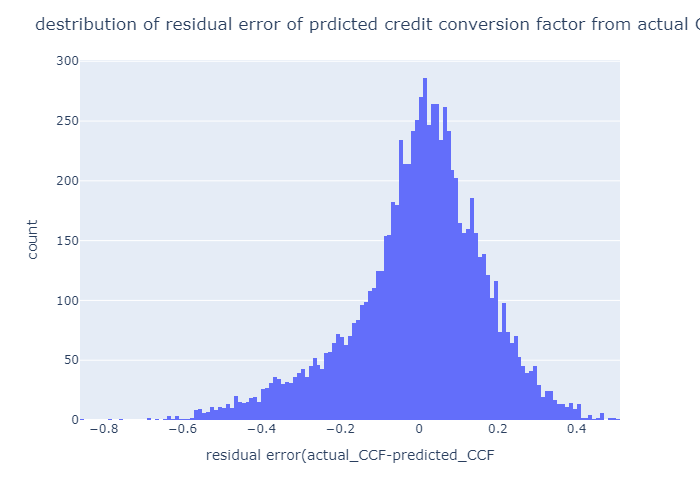

In [74]:
CCF_predi_actual['residual_Err']=CCF_predi_actual['actualCCF']-CCF_predi_actual['predictCCF']
fig=px.histogram(CCF_predi_actual,x='residual_Err')
fig.update_layout(title='destribution of residual error of prdicted credit conversion factor from actual Credit conversion factor',
                 xaxis=dict(title='residual error(actual_CCF-predicted_CCF'))
fig.show('png')

> from the above distribution plot of residual error it is observed that it is a neal normal distribtuion most of the residual error concentrated on zero value. So we can conclude that the model has trained properly.

# saving EAD model

In [75]:
pickle.dump(model_ead_LinearReg,open('EAD_Model_linearReg.sav','wb'))